<a href="https://colab.research.google.com/github/mekhi-woods/HiloCATsSN1991bg/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
START UP
"""
import os
import shutil
if os.path.exists('/content/HiloCATsSN1991bg') == True:
    shutil.rmtree('/content/HiloCATsSN1991bg')
    !git clone https://github.com/mekhi-woods/HiloCATsSN1991bg.git
else:
    !git clone https://github.com/mekhi-woods/HiloCATsSN1991bg.git

!pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple snpy
!pip install requests


In [ ]:
"""
Plotting 91bg like 1a to get an idea of what they look like
"""
import matplotlib.pyplot as plt
import numpy as np

FILTER_WHEEL = ['u', 'g', 'r', 'i', 'B', 'V0']

if __name__ == '__main__':
    KrisciunasPath = "/content/HiloCATsSN1991bg/targetLists/91bglike_justnames.txt"
    KrisciunasNames = np.genfromtxt(KrisciunasPath, dtype=str, delimiter=', ')

    allCPSPhot = "/content/HiloCATsSN1991bg/data/CSPdata/SN_photo.dat"
    allCPSPhotData = np.genfromtxt(allCPSPhot, dtype='str')

    names = allCPSPhotData[:,0]
    filters = allCPSPhotData[:,1]
    time = allCPSPhotData[:,2]
    light = allCPSPhotData[:,3]
    err = allCPSPhotData[:,4]

    plt.figure(figsize=(10,6))
    sigma = 1
    for tar in KrisciunasNames:
        for n in range(len(FILTER_WHEEL)):
            # output_names = names[(names == tar) & (filters == FILTER_WHEEL[n])]
            output_light = light[(names == tar) & (filters == FILTER_WHEEL[n])].astype('float64')
            output_time = time[(names == tar) & (filters == FILTER_WHEEL[n])].astype('float64') + 53000
            output_err = err[(names == tar) & (filters == FILTER_WHEEL[n])].astype('float64')
            plt.errorbar(output_time, output_light, yerr=output_err*sigma, fmt='o', label=FILTER_WHEEL[n])

        plt.title(tar); plt.xlabel('Time [MJD]'); plt.ylabel('Intensity [mag]')
        plt.gca().invert_yaxis()
        plt.legend()
        # plt.savefig('save\\'+str(tar)+'.png')
        plt.show()
        break


In [ ]:
"""
SNooPy fitting on CSP data
"""
import matplotlib.pyplot as plt
import numpy as np
import snpy
import os
from zipfile import ZipFile

USE_SAVED = False

def recover_dir():
    if os.path.exists('/content/saved_models') == False:
        os.mkdir('/content/saved_models')
    if os.path.exists('/content/snpy_fit_plots') == False:
        os.mkdir('/content/snpy_fit_plots')
    if os.path.exists('/content/snpy_fit_plots/snpyplots.zip'):
        os.remove('/content/snpy_fit_plots/snpyplots.zip')
    return

def snpy_fit(filePath, model='max_model', shapeParam='dm15', BandsToFit = ['B','g','r','i'], summarize=True, saveplots=False, saveLoc='/content/snpy_fit_plots/'):
    s = snpy.get_sn(filePath)

    # Set model parameters
    s.choose_model(model, stype=shapeParam)
    s.set_restbands() # Auto pick appropriate rest-bands

    # Fit data -- using David configurations
    fitargs = {'mangle':1,'calibration':0, 'quiet':False} # I don't remember what calibration is
    s.fit(BandsToFit,
          dokcorr=True,
          k_stretch=False,
          reset_kcorrs=True,
          **fitargs)

    # Show results
    if summarize:
        s.summary()
        # for param in s.parameters:
        #     print("{} = {} +/- {}".format(param, s.parameters[param], s.errors[param]))
    if saveplots:
        print('Plot saved @', saveLoc+filePath[-17:-9]+'_snpyplots')
        s.plot(outfile=saveLoc+filePath[-17:-9]+'_snpyplots')
        plt.show()

        with ZipFile('/content/snpy_fit_plots/snpyplots.zip', 'a') as zip_object:
            zip_object.write(saveLoc+filePath[-17:-9]+'_snpyplots.png')

    return s

def SNooPy2_fitting(CPSpath, tarNames, model='EBV_model2', shape='st', bands=['B','g','r','i'], output=False, snpyPlots=False):
    problemChildren = []

    if len(bands) == 0:
        bands = None

    tarPaths = []
    for tar in tarNames:
        tarPaths.append(CPSpath+'/SN'+str(tar)+'_snpy.txt')

    SNeDistances = {}
    SNeRedshifts = {}

    for i in range(len(tarPaths)):
        tarName = 'SN'+tarNames[i]
        tarSave = '/content/saved_models/'+tarName+'_'+model+'.snpy'
        print('[ '+str(i+1)+' / '+str(len(tarPaths))+'] Fiting data for '+tarName+'...')

        # Create/Retrieve Fit
        valid = True

        if os.path.exists(tarSave) and USE_SAVED:
            print(tarName, 'found in files! Pulling data...')
            s_n = snpy.get_sn(tarSave)
        elif os.path.exists(tarPaths[i]):
            try:
                s_n = snpy_fit(tarPaths[i],
                                model=model,
                                shapeParam=shape,
                                BandsToFit=None,
                                summarize=output,
                                saveplots=snpyPlots,
                                saveLoc='/content/snpy_fit_plots/') # Enter snpy fit function
            except ValueError:
                problemChildren.append(tarName)
                print('[!!!] ValueError: No data near maximum light... skipping\n')
                valid = False
            except RuntimeError:
                problemChildren.append(tarName)
                print('[!!!] RuntimeError: Model has trailed off fitting filter... skipping\n')
                valid = False
            except TypeError:
                problemChildren.append(tarName)
                print('[!!!] TypeError: m > k must hold (I have no clue what this means)... skipping\n')
                valid = False
        else:
            print(tarName, 'does not exsist in CSP data... skipping')
            valid = False

        if valid:
            # Save model
            s_n.save(tarSave)

            # Pull SNooPY distance
            snpy_mu = s_n.get_distmod() # Nab paramaters from SNe objects)

            # Update dictionary/list
            SNeDistances.update({tarName: snpy_mu})
            SNeRedshifts.update({tarName: s_n.z})

            # Print info
            print('Redshift:\t z = '+str(s_n.z))
            print('Distance: \t mu = '+str(round(snpy_mu, 4))+'\n')

    print('Problem children:\n', '[', len(problemChildren), ']', problemChildren)
    plt.clf()
    return SNeDistances, SNeRedshifts

def plot_DvD(snpyDistances, burnsDistances, size=(8,5), save=False):
    print("Ploting differences in distance calculations...")
    plt.figure(figsize=size)
    for x in snpyDistances:
        try:
            plt.scatter(burnsDistances[x], snpyDistances[x], marker='o')
            plt.text(burnsDistances[x]+0.05, snpyDistances[x]-0.05, x, fontsize='xx-small')
            print('Burns Distance:', burnsDistances[x], '| SNooPy Distance:', snpyDistances[x])
        except KeyError:
            print(x, 'not found.')
            pass
    plt.title("Burns v. SNooPy Distance")
    plt.xlabel('Burns Distance'); plt.ylabel('SNooPy Distance')
    plt.xlim(min(burnsDistances.values()), max(burnsDistances.values()))
    plt.ylim(min(burnsDistances.values()), max(burnsDistances.values()))

    if save:
        plt.savefig('burns_v_snpy_dist.png')

    plt.show()
    return

def plot_residuals(snpyDistances, burnsDistances, snpyRedshifts, size=(8,5), save=False):
    print("Ploting residuals...")
    plt.figure(figsize=size)
    for x in snpyDistances:
        try:
            plt.scatter(snpyRedshifts[x], abs(burnsDistances[x]-snpyDistances[x]), marker='o')
            plt.text(snpyRedshifts[x], abs(burnsDistances[x]-snpyDistances[x]), x, fontsize='xx-small')
            print('Redshift:', snpyRedshifts[x], '| Burns-SNooPy Distance:', burnsDistances[x]-snpyDistances[x])
        except KeyError:
            print(x, 'not found.')
            pass
    plt.title("Burns-SNooPy Residuals"); plt.xlabel('Redshift'); plt.ylabel('Burns-SNooPy')
    if save:
        plt.savefig('burns-snpy_res.png')
    plt.show()
    return

if __name__ == '__main__':
    recover_dir()

    # Initialize Data
    KrisciunasNames = np.genfromtxt("/content/HiloCATsSN1991bg/targetLists/91bglike_justnames.txt", dtype=str, delimiter=', ')

    burnsData = np.genfromtxt('/content/HiloCATsSN1991bg/targetLists/burns+25table2ext.txt', dtype=str)
    burnsDistances = {}
    burnsNames = burnsData[:, 0]
    for tar in np.stack((burnsData[:, 0], burnsData[:, 14]), axis=1):
        burnsDistances.update({'SN'+tar[0]: float(tar[1])})

    # Fitting Data
    snpyDistances, snpyRedshifts = SNooPy2_fitting(CPSpath='/content/HiloCATsSN1991bg/data/CSPdata',
                                                   tarNames=KrisciunasNames,
                                                   model='EBV_model2',
                                                   shape='st',
                                                   bands=['B','g','r','i'],
                                                   output=False,
                                                   snpyPlots=True)

    # Plot Distance v. Distance
    plot_DvD(snpyDistances, burnsDistances, size=(8,5), save=True)

    # Plot Residuals
    plot_residuals(snpyDistances, burnsDistances, snpyRedshifts, size=(8,5), save=True)


[ 1 / 83 ] Slicing 1173857301744945700...
[ 2 / 83 ] Slicing 1122418881102646700...
[ 3 / 83 ] Slicing 1045902220002631500...
[ 4 / 83 ] Slicing 1022141900255539900...
[ 5 / 83 ] Slicing 1162512461405024700...
[ 6 / 83 ] Slicing 1061033320143219100...
[ 7 / 83 ] Slicing 1040239171251401300...
[ 8 / 83 ] Slicing 1041641640121059200...
[ 9 / 83 ] Slicing 1114428341104702000...
[!!!] File empty...skipping
[ 10 / 83 ] Slicing 1012958111192621400...
[ 11 / 83 ] Slicing 1124332160412157900...
[ 12 / 83 ] Slicing 1044255161003703900...
[ 13 / 83 ] Slicing 1144509771091625100...
[ 14 / 83 ] Slicing 1224726940253954200...
[ 15 / 83 ] Slicing 1013624701220300200...


<ipython-input-12-cfc365a0f2d1>:126: UserWarning: genfromtxt: Empty input file: "/content/ATLAS/1114428341104702000.txt"
  data = np.genfromtxt(path, dtype=str, delimiter=',')


[ 16 / 83 ] Slicing 1060340020263946800...
[ 17 / 83 ] Slicing 1140849041353649800...
[ 18 / 83 ] Slicing 1211500761215435700...
[ 19 / 83 ] Slicing 1034109200025054700...
[ 20 / 83 ] Slicing 1084621190123922600...
[ 21 / 83 ] Slicing 1235527530345232200...
[ 22 / 83 ] Slicing 1062134810271253600...
[ 23 / 83 ] Slicing 1133245250130248700...
[ 24 / 83 ] Slicing 1203109300441544500...
[ 25 / 83 ] Slicing 1133923001510301000...
[ 26 / 83 ] Slicing 1160723401135334100...
[ 27 / 83 ] Slicing 1142046990194710500...
[ 28 / 83 ] Slicing 1111155951030803400...
[ 29 / 83 ] Slicing 1012551870012203900...
[ 30 / 83 ] Slicing 1191628721415324300...
[ 31 / 83 ] Slicing 1150925521252818000...
[ 32 / 83 ] Slicing 1003753320212821500...
[ 33 / 83 ] Slicing 1050523630115258100...
[ 34 / 83 ] Slicing 1000438990080559900...
[ 35 / 83 ] Slicing 1091500861223522500...
[ 36 / 83 ] Slicing 1143801871101102900...
[ 37 / 83 ] Slicing 1122632231312545000...
[ 38 / 83 ] Slicing 1094248210033625300...
[ 39 / 83 ]

<ipython-input-12-cfc365a0f2d1>:126: UserWarning: genfromtxt: Empty input file: "/content/ATLAS/1040121830544516000.txt"
  data = np.genfromtxt(path, dtype=str, delimiter=',')
<ipython-input-12-cfc365a0f2d1>:126: UserWarning: genfromtxt: Empty input file: "/content/ATLAS/1140215111094659400.txt"
  data = np.genfromtxt(path, dtype=str, delimiter=',')


83 ] Slicing 1094114161260519800...
[ 59 / 83 ] Slicing 1063155011353323600...
[ 60 / 83 ] Slicing 1114107741244910900...
[ 61 / 83 ] Slicing 1234414950233145500...
[ 62 / 83 ] Slicing 1015632581035137300...
[ 63 / 83 ] Slicing 1091642021185754300...
[ 64 / 83 ] Slicing 1121801910205127500...
[ 65 / 83 ] Slicing 1021103151362854900...
[ 66 / 83 ] Slicing 1045103970055725100...
[ 67 / 83 ] Slicing 1125853461280737700...
[ 68 / 83 ] Slicing 1050103890382654300...
[ 69 / 83 ] Slicing 1081524570065727100...
[ 70 / 83 ] Slicing 1023822740114421300...
[ 71 / 83 ] Slicing 1221646471865557100...
[ 72 / 83 ] Slicing 1141702841104919500...
[ 73 / 83 ] Slicing 1212339461393450700...
[ 74 / 83 ] Slicing 1104330091190458400...
[ 75 / 83 ] Slicing 1160106271192701200...
[ 76 / 83 ] Slicing 1171607251404714200...
[ 77 / 83 ] Slicing 1130014611275725700...
[ 78 / 83 ] Slicing 1010348331103532600...
[ 79 / 83 ] Slicing 1115510700075033500...
[ 80 / 83 ] Slicing 1010733071322429400...
[ 81 / 83 ] Slicin

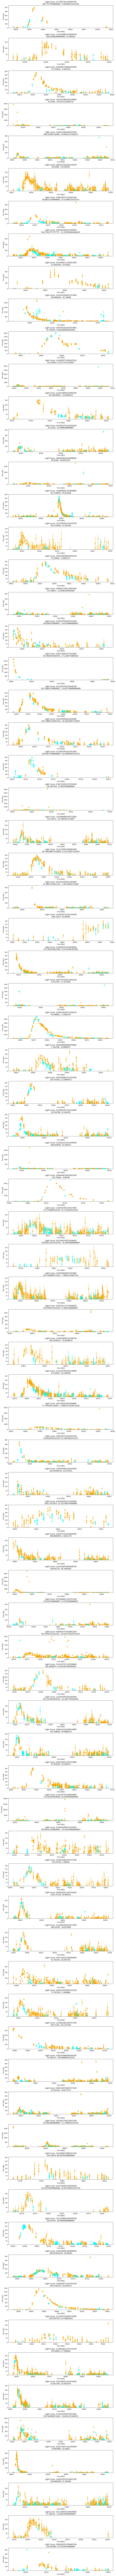

In [12]:
"""
ATLAS Data
"""
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import requests
import os
import glob
from requests.auth import HTTPBasicAuth
from zipfile import ZipFile

API_TOKEN = "7f4e1dee8f52cf0c8cdaf55bf29d04bef4810fb4"
ATLAS_PATH = '/content/ATLAS'
N_ITER = -1 # -1 turns iteration limit off
PLOT_MODE = 'COMBINED' # SOLO or COMBINED

def recover_dir():
    if os.path.exists(ATLAS_PATH) == False:
        os.mkdir(ATLAS_PATH)
    if os.path.exists('/content/ATLASplots') == False:
        os.mkdir('/content/ATLASplots')
    return

def data_collection():
        if os.path.exists('/content/tmp.npz'):
            pickle = np.load('tmp.npz', allow_pickle=True)
            data = pickle['data']

        data = requests.post(
            'https://star.pst.qub.ac.uk/sne/atlas4/api/objectlist/',
            headers={'Authorization': f'Token {API_TOKEN}'},
            data={'objectlistid':2}
        ).json()

        np.savez('tmp.npz', data=data)

        count = 0
        for d in data:
            if d['observation_status'] is not None and d['observation_status'].startswith('SN Ia') and '91bg' in d['observation_status']:
                print(d['atlas_designation'],d['observation_status'].replace(' ',''),d['ra'],d['dec'])
                count += 1

                ids = d['id']
                base_url = 'https://star.pst.qub.ac.uk/sne/atlas4/lightcurveforced/1161048951013729300/'
                new_url = base_url.replace('1161048951013729300/',str(ids))
                print(new_url)

                idfile = ATLAS_PATH+'/' + str(ids)+'.txt'
                if os.path.exists(idfile):
                    continue
                urllib.request.urlretrieve(str(new_url), str(idfile))
                print(idfile)

            if count > 300:
                break

def main_processing():
    # [2.1] Aquire Data
    err_max = 50 # Max error before considered outlier
    ATLASfiles = glob.glob(ATLAS_PATH+'/*')
    validData_o, validData_c, validCoords = {}, {}, {}
    problemChildren = ['1032212120425304400']   # Running list of problematic SNe
                                                # '1032212120425304400' - David believes it might be a shock breakout but ATLAS reports it as SN1a
                                                #
    # [2.2] Validate Data
    for n in range(len(ATLASfiles)):
        path = ATLASfiles[n]
        name = path[15:-4]

        print("[", n+1, "/", len(ATLASfiles), "] Slicing "+name+'...')
        data_o, data_c, coords, filters = slice_data(path, err_max, output=False)
        if data_o != None or data_c != None:
            validData_o.update({name : (data_o[0], data_o[1])})
            validData_c.update({name : (data_c[0], data_c[1])})
            validCoords.update({name : coords})
        else:
            problemChildren.append(name)
        if N_ITER != -1 and n > N_ITER:
            break
    # [2.3] Remove problem children
    print('Problem Children: ', problemChildren)
    for key in problemChildren:
        if key in validData_o:
            print('Removing...', key)
            del validData_o[key]
            del validData_c[key]
            del validCoords[key]
        else:
            print('Already removed...', key)
    print('\n')

    # [2.4] Saved RA & Dec
    with open('ATLASCoordinates.txt', 'w') as f:
        for tar in validCoords:
            f.write(str(validCoords[tar][0])+', '+str(validCoords[tar][1])+'\n')

    # [2.5] Plot data
    if PLOT_MODE == 'SOLO':
        print("Plotting data [indivisual]...")
        with ZipFile('/content/ATLASplots/ATLASplots.zip', 'w') as zip_object:
            for name in validData_o:
                solo_plotting(validData_o[name][0], validData_c[name][0],
                              validData_o[name][1][:, 0], validData_c[name][1][:, 0],
                              validData_o[name][1][:, 1], validData_c[name][1][:, 1],
                              err_max, name=name, coords=validCoords[name], save=True)
                zip_object.write('/content/ATLASplots/'+name+'_ATLASplot.png')
                print(validCoords[name])

    elif PLOT_MODE == 'COMBINED':
        print("Plotting data [combined]...")
        fig, axs = plt.subplots(len(validData_o.keys()), figsize=(12, len(validData_o.keys())*3.2))
        fig.tight_layout(pad=5.0)
        for n in range(len(validData_o.keys())):
            name = list(validData_o.keys())[n]
            combined_plotting(axs[n], validData_o[name][0], validData_c[name][0],
                              validData_o[name][1][:, 0], validData_c[name][1][:, 0],
                              validData_o[name][1][:, 1], validData_c[name][1][:, 1],
                              name=name, coords=validCoords[name])
            if N_ITER != -1 and n > N_ITER:
                break
    return validData_c, validData_o

def slice_data(path, err_max=100, output=True):
    expname = path[15:-4]
    data = np.genfromtxt(path, dtype=str, delimiter=',')
    if len(data) == 0:
        print('[!!!] File empty...skipping')
        return None, None, None, None
    else:
        t = data[:, 8].astype(float)
        uJy = np.where(data[:, 24] == 'None', np.nan, data[:, 24]).astype(float)
        uJy_err = np.where(data[:, 25] == 'None', np.nan, data[:, 25]).astype(float)
        coords = [data[0, 1].astype(float), data[0, 2].astype(float)]
        filters = data[:, 6]

    # Remove Outliers
    outliers = np.where(abs(uJy_err) > err_max)[0]
    if output:
        print('Outliers: ', outliers,'\n\t  ', uJy[outliers])
    for n in np.flip(outliers):
        t = np.delete(t, n)
        uJy = np.delete(uJy, n)
        uJy_err = np.delete(uJy_err, n)
        filters = np.delete(filters, n)

    t_o = t[np.where(filters=='o')[0]]
    t_c = t[np.where(filters=='c')[0]]
    uJy_o = np.stack((uJy[np.where(filters=='o')[0]], uJy_err[np.where(filters=='o')[0]]), axis=1)
    uJy_c = np.stack((uJy[np.where(filters=='c')[0]], uJy_err[np.where(filters=='c')[0]]), axis=1)

    data_o = [t_o, uJy_o]
    data_c = [t_c, uJy_c]

    return data_o, data_c, coords, filters

def solo_plotting(t_o, t_c, flux_o, flux_c, flux_err_o, flux_err_c, err_max, name='Empty', coords=[0, 0], size=(12, 4), save=False, saveLoc='/content/ATLASplots/'):
    plt.figure(figsize=size)

    plt.errorbar(t_o, flux_o, yerr=flux_err_o, fmt='o', color='orange')
    plt.errorbar(t_c, flux_c, yerr=flux_err_c, fmt='o', color='cyan')

    plt.title('Light Curve: '+str(name)+'\n'+str(coords[0])+', '+str(coords[1])+'\nMax Error = '+str(err_max))
    plt.xlabel('Time [MJD]')
    plt.ylabel('Flux [uJy]')
    plt.ylim(0)
    plt.savefig(saveLoc+name+'_ATLASplot.png')
    plt.show()
    return

def combined_plotting(ax, t_o, t_c, flux_o, flux_c, flux_err_o, flux_err_c, name='Empty', coords=[0, 0]):
    ax.errorbar(t_o, flux_o, yerr=flux_err_o, fmt='o', color='orange')
    ax.errorbar(t_c, flux_c, yerr=flux_err_c, fmt='o', color='cyan')

    ax.set_title('Light Curve: '+str(name)+'\n'+str(coords[0])+', '+str(coords[1]))
    ax.set_xlabel('Time [MJD]')
    ax.set_ylabel('Flux [uJy]')
    ax.set_ylim(0)
    return

if __name__ == '__main__':

    # # [1] Run first - then comment out
    # recover_dir()
    # data_collection()

    # [2] Slice data, remove outliers, & plot
    cData, oData = main_processing()

    # [3] Redshift v. distance modulus



In [ ]:
"""
DR3's Tmax vs. st vs EBVhost
"""
import matplotlib.pyplot as plt
import numpy as np

if __name__ == "__main__":
    data = np.genfromtxt('/content/HiloCATsSN1991bg/DR3_fits.dat', dtype=str, skip_header=1)
    DR3_st = np.stack((data[:, 1].astype(float), data[:, 2].astype(float)), axis=1)
    DR3_Tmax = np.stack((data[:, 5].astype(float), data[:, 6].astype(float)), axis=1)
    DR3_EBVhost = np.stack((data[:, 25].astype(float), data[:, 26].astype(float)), axis=1)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5))
    fig.suptitle("DR3's Tmax vs. st vs EBVhost")
    sigmas = [[1, 1], [1, 1], [1, 1]]

    # Tmax vs. st
    ax1.errorbar(DR3_Tmax[:, 0], DR3_st[:, 0],
                 xerr=DR3_Tmax[:, 1]*sigmas[0][0], yerr=DR3_st[:, 1]*sigmas[0][1],
                 fmt='yo')
    ax1.set_xlabel('Tmax'); ax1.set_ylabel('st')
    ax1.set_title('Tmax vs. st, sigma(x='+str(sigmas[0][0])+', y='+str(sigmas[0][1])+')')

    # st vs. EBVhost
    ax2.errorbar(DR3_st[:, 0], DR3_EBVhost[:, 0],
                 xerr=DR3_st[:, 1]*sigmas[1][0], yerr=DR3_EBVhost[:, 1]*sigmas[1][1],
                 fmt='bo')
    ax2.set_xlabel('st'); ax2.set_ylabel('EBVhost')
    ax2.set_title('st vs. EBVhost, sigma(x='+str(sigmas[1][0])+', y='+str(sigmas[1][1])+')')

    # Tmax vs. EBVhost
    ax3.errorbar(DR3_Tmax[:, 0], DR3_EBVhost[:, 0],
                 xerr=DR3_Tmax[:, 1]*sigmas[2][0], yerr=DR3_EBVhost[:, 1]*sigmas[2][1],
                 fmt='ro')
    ax3.set_xlabel('Tmax'); ax3.set_ylabel('EBVhost')
    ax3.set_title('Tmax vs. EBVhost, sigma(x='+str(sigmas[2][0])+', y='+str(sigmas[2][1])+')')

    plt.show()
